# Deep Learning Prediction Workflow
Predict daily household electricity consumption from weather + recent usage.
Trains three sequence models (LSTM, GRU, temporal CNN), visualizes performance, and saves artifacts.


In [1]:
%pip install -q torch pandas scikit-learn matplotlib seaborn joblib kaggle holidays
# Uncomment above if your environment is missing dependencies


In [2]:
import os
import subprocess
from pathlib import Path

GITHUB_URL = "https://github.com/HolikGellert/Projektmunka.git"
REPO_PATH = "/content/Projektmunka"

print("Setting up repository from GitHub...")

if not os.path.exists(REPO_PATH):
    # Clone if it doesn't exist
    print(f"Cloning from {GITHUB_URL}...")
    subprocess.run(["git", "clone", GITHUB_URL, REPO_PATH], check=True)
    print(f"✓ Cloned to {REPO_PATH}")
else:
    # Pull latest changes if it already exists
    print(f"Repository already exists at {REPO_PATH}")
    print("Pulling latest changes...")
    subprocess.run(["git", "-C", REPO_PATH, "pull"], check=True)
    print("✓ Pulled latest changes")

# Verify the structure
print(f'\n=== Repo structure ===')
repo_root = Path(REPO_PATH)

# Find prediction/ directory
prediction_dir = repo_root / 'prediction'
if prediction_dir.is_dir():
    print(f'✓ Found prediction/ at {prediction_dir}')
    print(f'  Config: {(prediction_dir / "config.py").is_file()}')
    print(f'  src/: {(prediction_dir / "src").is_dir()}')
else:
    # Search recursively
    found = False
    for root, dirs, files in os.walk(REPO_PATH):
        if 'prediction' in dirs:
            print(f'✓ Found prediction/ at {root}/prediction')
            found = True
            break
    if not found:
        print('✗ prediction/ directory not found')

Setting up repository from GitHub...
Repository already exists at /content/Projektmunka
Pulling latest changes...
✓ Pulled latest changes

=== Repo structure ===
✓ Found prediction/ at /content/Projektmunka/prediction
  Config: True
  src/: True


In [3]:
import sys
import os
from pathlib import Path

# Search for prediction/ directory starting from /content
REPO_ROOT = None

# Check multiple possible locations
search_paths = [
    Path('/content/Projektmunka'),
    Path('/content/Projektmunka/Projektmunka'),
    Path('/content'),
]

print('Searching for prediction/ directory...')
for search_path in search_paths:
    if search_path.exists():
        print(f'  Checking {search_path}...', end=' ')
        if (search_path / 'prediction').is_dir():
            REPO_ROOT = search_path
            print('✓ Found!')
            break
        else:
            print('✗')

if REPO_ROOT is None:
    # List what's actually in /content
    print('\n✗ Could not find prediction/ directory')
    print('\nContents of /content:')
    if Path('/content').exists():
        for item in os.listdir('/content'):
            item_path = Path('/content') / item
            marker = '📁' if item_path.is_dir() else '📄'
            print(f'  {marker} {item}')
    raise RuntimeError(
        'prediction/ directory not found.\n'
        'The Git clone may have created a different structure.\n'
        'Check the output above to see what was actually cloned.'
    )

print(f'\n✓ Repo root: {REPO_ROOT}')
print(f'✓ Prediction dir: {(REPO_ROOT / "prediction").is_dir()}')
print(f'✓ Config file: {(REPO_ROOT / "prediction" / "config.py").is_file()}')

# Add to sys.path
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
print(f'✓ CUDA available: {torch.cuda.is_available()}')

Searching for prediction/ directory...
  Checking /content/Projektmunka... ✓ Found!

✓ Repo root: /content/Projektmunka
✓ Prediction dir: True
✓ Config file: True
✓ CUDA available: True


In [4]:
import subprocess
from pathlib import Path
import shutil

print('=== Setting up data from GitHub LFS ===\n')

# Ensure Git LFS is available
print('Checking for Git LFS...')
try:
    result = subprocess.run(['git', 'lfs', '--version'], capture_output=True, text=True)
    print(f'✓ {result.stdout.strip()}')
except FileNotFoundError:
    print('⚠ Git LFS not found. Installing...')
    subprocess.run(['apt-get', 'update'], capture_output=True)
    subprocess.run(['apt-get', 'install', '-y', 'git-lfs'], capture_output=True)
    subprocess.run(['git', 'lfs', 'install'], check=True)
    print('✓ Git LFS installed')

# Pull LFS files from the cloned repo
repo_root = Path('/content/Projektmunka')
print(f'\nPulling LFS files from {repo_root}...')

try:
    subprocess.run(['git', '-C', str(repo_root), 'lfs', 'pull'], 
                   capture_output=True, text=True, timeout=120, check=True)
    print('✓ Git LFS pull completed')
except subprocess.CalledProcessError as e:
    print(f'⚠ Git LFS pull warning: {e.stderr}')
    print('  Attempting to continue anyway...')

# Look for CSV files in the cloned repo
print('\n=== Looking for CSV files in repo ===')
search_dirs = [
    repo_root / 'prediction' / 'data',
    repo_root / 'data' / 'raw',
    repo_root / 'data',
]

found_daily = None
found_weather = None

for search_dir in search_dirs:
    if search_dir.exists():
        daily_f = search_dir / 'daily_dataset.csv'
        weather_f = search_dir / 'london_weather.csv'
        if daily_f.exists():
            found_daily = daily_f
            print(f'✓ Found daily_dataset.csv in {search_dir.relative_to(repo_root)}')
        if weather_f.exists():
            found_weather = weather_f
            print(f'✓ Found london_weather.csv in {search_dir.relative_to(repo_root)}')

if found_daily is None or found_weather is None:
    print('\n✗ Could not find CSV files')
    print('Missing:')
    if found_daily is None:
        print('  - daily_dataset.csv')
    if found_weather is None:
        print('  - london_weather.csv')
    raise FileNotFoundError('CSV files not found in GitHub repo')

# Copy to working directory
print('\n=== Copying to working directory ===')
data_dir = repo_root / 'prediction' / 'data'
data_dir.mkdir(parents=True, exist_ok=True)

for src_file in [found_daily, found_weather]:
    if src_file and src_file.exists():
        dst_file = data_dir / src_file.name
        # Only copy if not already in the target location
        if str(src_file) != str(dst_file):
            shutil.copy2(str(src_file), str(dst_file))
            print(f'✓ Copied {src_file.name}')
        else:
            print(f'✓ {src_file.name} already in place')
        size_mb = dst_file.stat().st_size / (1024**2)
        print(f'  Size: {size_mb:.1f} MB')

print('\n✓ Data setup complete!')


=== Setting up data from GitHub LFS ===

Checking for Git LFS...
✓ git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)

Pulling LFS files from /content/Projektmunka...
✓ Git LFS pull completed

=== Looking for CSV files in repo ===
✓ Found daily_dataset.csv in prediction/data
✓ Found london_weather.csv in prediction/data
✓ Found daily_dataset.csv in data/raw
✓ Found london_weather.csv in data/raw

=== Copying to working directory ===
✓ Copied daily_dataset.csv
  Size: 97.3 MB
✓ Copied london_weather.csv
  Size: 0.8 MB

✓ Data setup complete!


## Data prep
Merge energy + weather, add temporal features, scale, and build sliding-window sequences for the models.


In [5]:
from prediction.config import PredictionConfig as Config
from prediction.src.data_prep import PredictionDataPrep

prep = PredictionDataPrep()
merged_df = prep.add_features(prep.load_raw())
seq_data = prep.build_sequences(merged_df)
X_train, X_val, X_test, y_train, y_val, y_test = prep.train_val_test_split(seq_data)

print('Merged shape:', merged_df.shape)
print('Sequence tensor:', seq_data.X.shape)
print('Split sizes:', len(X_train), len(X_val), len(X_test))


Merged shape: (3498239, 26)
Sequence tensor: (3381518, 21, 16)
Split sizes: 2705216 338151 338151


## Build dataloaders
Splits sequences into train/validation sets.


In [6]:
from prediction.src.train_utils import create_dataloaders, save_scaler, make_loader

train_loader, val_loader = create_dataloaders(X_train, y_train, X_val, y_val, batch_size=Config.BATCH_SIZE)
test_loader = make_loader(X_test, y_test, batch_size=Config.BATCH_SIZE, shuffle=False)
save_scaler(seq_data.scaler)
len(train_loader), len(val_loader), len(test_loader)


(10568, 1321, 1321)

## Train models
Train an LSTM, GRU, and temporal CNN; log histories and persist weights.


In [7]:
from prediction.src.models import LSTMRegressor, GRURegressor, TemporalCNNRegressor
from prediction.src.train_utils import train_model, save_model, save_metadata, evaluate_mae

input_size = len(seq_data.feature_cols)
models = {
    'lstm': (LSTMRegressor(input_size=input_size), Config.LSTM_MODEL_PATH),
    'gru': (GRURegressor(input_size=input_size), Config.GRU_MODEL_PATH),
    'tcn': (TemporalCNNRegressor(input_size=input_size), Config.CNN_MODEL_PATH),
}

histories = {}
metrics = {}
for name, (model, path) in models.items():
    print(f'\nTraining {name.upper()}...')
    history = train_model(
        model,
        train_loader,
        val_loader,
        epochs=Config.EPOCHS,
        lr=Config.LEARNING_RATE,
        weight_decay=Config.WEIGHT_DECAY,
        grad_clip=Config.GRAD_CLIP,
        max_batches=Config.MAX_TRAIN_BATCHES,
        early_stop_patience=Config.EARLY_STOP_PATIENCE,
    )
    val_mae = evaluate_mae(model, val_loader, max_batches=Config.MAX_EVAL_BATCHES)
    test_mae = evaluate_mae(model, test_loader, max_batches=Config.MAX_EVAL_BATCHES)
    save_model(model, path)
    histories[name] = history
    metrics[name] = {'val_mae': val_mae, 'test_mae': test_mae}

metadata = {
    'feature_cols': seq_data.feature_cols,
    'lookback': seq_data.lookback,
    'metrics': metrics,
}
save_metadata(metadata)
metrics



Training LSTM...
Epoch 1/1 - train_loss=12.7061 val_loss=10.8369

Training GRU...
Epoch 1/1 - train_loss=12.1653 val_loss=10.5254

Training TCN...
Epoch 1/1 - train_loss=15.9602 val_loss=15.7887


{'lstm': {'val_mae': 1.88987135887146, 'test_mae': 2.0009090900421143},
 'gru': {'val_mae': 1.8856632709503174, 'test_mae': 1.9947761297225952},
 'tcn': {'val_mae': 2.291486978530884, 'test_mae': 2.4122133255004883}}

## Plot training curves


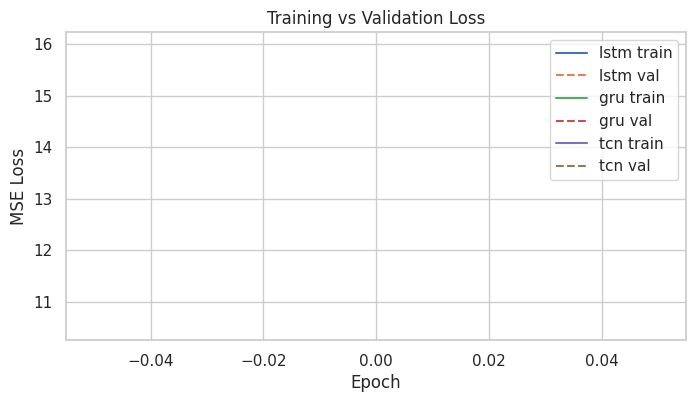

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
for name, hist in histories.items():
    ax.plot(hist['train_loss'], label=f'{name} train')
    ax.plot(hist['val_loss'], linestyle='--', label=f'{name} val')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
ax.legend()
ax.set_title('Training vs Validation Loss')
plt.show()


## Inspect predictions
Visual sanity check on a validation batch.


Model device: cuda:0


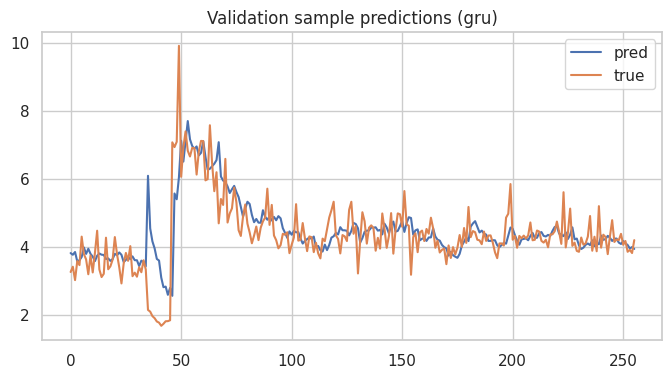

In [9]:
# Choose best model based on validation MAE and visualize a batch
model_key = min(metrics, key=lambda k: metrics[k]['val_mae'])
best_model = models[model_key][0]
best_model.eval()

# Get device from model
device = next(best_model.parameters()).device
print(f'Model device: {device}')

batch_X, batch_y = next(iter(val_loader))
# Move batch to same device as model
batch_X = batch_X.to(device)
batch_y = batch_y.to(device)

with torch.no_grad():
    preds = best_model(batch_X).squeeze().cpu().numpy()
truth = batch_y.squeeze().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(preds, label='pred')
plt.plot(truth, label='true')
plt.title(f'Validation sample predictions ({model_key})')
plt.legend()
plt.show()


## Inspect test predictions
Quick visual check of the best model on a test batch.


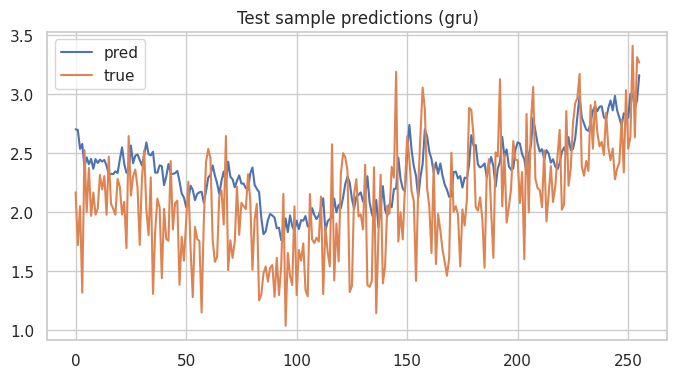

In [10]:
# Visualize a batch from the held-out test set
batch_X_test, batch_y_test = next(iter(test_loader))
batch_X_test = batch_X_test.to(device)
batch_y_test = batch_y_test.to(device)

with torch.no_grad():
    test_preds = best_model(batch_X_test).squeeze().cpu().numpy()
test_truth = batch_y_test.squeeze().cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(test_preds, label='pred')
plt.plot(test_truth, label='true')
plt.title(f'Test sample predictions ({model_key})')
plt.legend()
plt.show()


**Save & Push Artifacts to GitHub**

The notebook can save the trained model (`.pt`) and the feature scaler (`.pkl`) into the cloned repository and push them back to GitHub.

Important: Pushing to GitHub requires authentication. You can either provide a Personal Access Token (PAT) interactively (recommended for automation) or use the `gh` CLI web/device login flow. It is NOT possible to push to GitHub without any authentication.

This cell provides a safe helper that asks for a PAT at runtime (not stored in the notebook) or uses `gh auth login` to authenticate in your Colab session. If you prefer not to use GitHub, upload the files to Google Drive or download them locally from the Colab runtime.

In [11]:
# Helper: stage, commit and push artifacts (uses PAT or gh CLI)
from getpass import getpass
import subprocess
import shutil
from pathlib import Path
from prediction.config import PredictionConfig as Config

# Determine repo root (the notebook defines REPO_ROOT earlier when cloning)
repo_root = REPO_ROOT if 'REPO_ROOT' in globals() else Path.cwd()
repo_root = Path(repo_root)
print(f'Using repo root: {repo_root}')

def _to_repo_rel(p: Path) -> str:
    p = Path(p)
    if not p.exists():
        raise FileNotFoundError(f'Missing artifact: {p}')
    try:
        return str(p.relative_to(repo_root))
    except Exception:
        # Copy into repo if the artifact is outside the repo
        dst = repo_root / 'prediction' / 'models' / p.name
        dst.parent.mkdir(parents=True, exist_ok=True)
        if p.resolve() != dst.resolve():
            shutil.copy2(p, dst)
        return str(dst.relative_to(repo_root))

def _git(cmd: list, **kwargs):
    print('> git', ' '.join(cmd))
    return subprocess.run(['git'] + cmd, check=True, cwd=repo_root, **kwargs)

def push_with_pat(files, commit_message='Add trained artifacts', repo_owner='HolikGellert', repo_name='Projektmunka'):
    token = getpass('Enter a GitHub Personal Access Token (with repo permissions): ')
    if not token:
        print('No token provided, aborting.')
        return
    remote_url = f'https://{token}@github.com/{repo_owner}/{repo_name}.git'
    try:
        subprocess.run(['git','remote','add','temp-auth',remote_url], check=True, cwd=repo_root)
    except subprocess.CalledProcessError:
        print('Remote already exists; continuing.')
    try:
        rels = [_to_repo_rel(Path(f)) for f in files]
        _git(['add'] + rels)
        try:
            _git(['commit','-m',commit_message,'--author','Leibi7 <leibi.bence@gmail.com>'])
        except subprocess.CalledProcessError:
            print('Nothing to commit (unchanged files).')
        _git(['push','temp-auth','HEAD'])
        print('Push succeeded.')
    finally:
        subprocess.run(['git','remote','remove','temp-auth'], cwd=repo_root)
        del token

def push_with_ghcli(files, commit_message='Add trained artifacts'):
    print('This will run an interactive `gh auth login` flow in your Colab session.')
    print('If you have not installed GitHub CLI, install it in your runtime first.')
    subprocess.run(['gh','auth','login','--hostname','github.com','--web'], check=True, cwd=repo_root)
    rels = [_to_repo_rel(Path(f)) for f in files]
    _git(['add'] + rels)
    try:
        _git(['commit','-m',commit_message,'--author','Leibi7 <leibi.bence@gmail.com>'])
    except subprocess.CalledProcessError:
        print('Nothing to commit (unchanged files).')
    _git(['push','origin','HEAD'])
    print('Push succeeded via gh CLI.')

# Find artifacts created by training
artifact_candidates = [str(Config.LSTM_MODEL_PATH), str(Config.GRU_MODEL_PATH), str(Config.CNN_MODEL_PATH), str(Config.SCALER_PATH)]
artifacts = [p for p in artifact_candidates if Path(p).exists()]
print('Detected artifacts:', artifacts)

if artifacts:
    print('Choose authentication method to push artifacts:')
    print('  1) Enter a Personal Access Token (recommended for automation)')
    print('  2) Use GitHub CLI interactive login (opens a browser/web flow)')
    choice = input('Enter 1 or 2 (or anything else to skip): ').strip()
    if choice == '1':
        push_with_pat(artifacts)
    elif choice == '2':
        push_with_ghcli(artifacts)
    else:
        print('Skipping push.')
else:
    print('No artifacts found to push. Ensure `save_model` and `save_scaler` were called and files exist.')

Using repo root: /content/Projektmunka
Detected artifacts: ['/content/Projektmunka/prediction/models/lstm_regressor.pt', '/content/Projektmunka/prediction/models/gru_regressor.pt', '/content/Projektmunka/prediction/models/tcn_regressor.pt', '/content/Projektmunka/prediction/models/feature_scaler.pkl']
Choose authentication method to push artifacts:
  1) Enter a Personal Access Token (recommended for automation)
  2) Use GitHub CLI interactive login (opens a browser/web flow)
> git add prediction/models/lstm_regressor.pt prediction/models/gru_regressor.pt prediction/models/tcn_regressor.pt prediction/models/feature_scaler.pkl
> git commit -m Add trained artifacts --author Leibi7 <leibi.bence@gmail.com>
Nothing to commit (unchanged files).
> git push temp-auth HEAD
Push succeeded.
